# Torch/NumPy practice

In [42]:
import math
import os
import random
import sys
from imghdr import tests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special.cython_special import logit

from tqdm import tqdm

In [43]:
torch.__version__

'2.5.1'

In [45]:
def relu_forward(x):
    return x * (x >= 0)


assert torch.all(F.relu(x) == relu_forward(x))

In [46]:
def elu_forward(x):
    alpha = 1.0
    ten = x.clone()
    ten[ten <= 0] = alpha * (torch.exp(ten[ten <= 0]) - 1)
    return ten


assert torch.allclose(F.elu(x), elu_forward(x), 1e-4)

In [47]:
def lrelu_forward(x, alpha):
    ten = x.clone()
    ten[x <= 0] = alpha * ten[ten <= 0]
    return ten


assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

Mish:

$$x \cdot tanh(ln(1+e^x))$$

In [48]:
def mish(inputs):
    return inputs * torch.tanh(torch.log(1 + torch.exp(inputs)))

In [49]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)),
    torch.tensor([0.8651, 0.8651, 0.8651]),
    atol=1e-4,
)

In [50]:
assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)),
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64),
    atol=1e-4,
)

Теперь реализуем swish, она выглядит следующим образом:

$$x \cdot \sigma(x)$$

In [51]:
def swish(x):
    return torch.mul(x, torch.sigmoid(x))


In [52]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)),
    torch.tensor([0.7311, 0.7311, 0.7311]),
    atol=1e-4,
)

In [53]:
assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)),
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64),
    atol=1e-4,
)

$$
f(x) = x^2 - 2x + 5 \to \min_{x}
$$

In [54]:
import torch

lr = 0.01
iterations = 10000
x = torch.tensor([3.], requires_grad=True)
for _ in range(iterations):
    z = x ** 2 - 2 * x + 5
    z.backward()
    with torch.no_grad():
        x -= lr * x.grad

    x.grad.zero_
print(x.item())

0.6449893712997437


# 2. Логистическая регрессия 

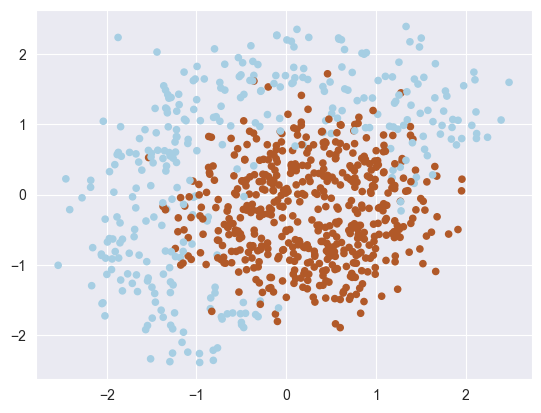

In [55]:
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True,
                               noise=0.2, factor=0.4, random_state=42)

ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

In [56]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [57]:
from torch.utils.data import Dataset, DataLoader, random_split

BATCH_SIZE = 32


class RandomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return {'sample': torch.tensor(self.X[idx, :], dtype=torch.float), 'target': self.y[idx]}

    def __len__(self):
        return len(self.X)


circle_data = RandomDataset(X, y)
train_size = int(circle_data.__len__() * 0.7)
val_size = int(circle_data.__len__() * 0.15)
test_size = int(circle_data.__len__() - train_size - val_size)
train_data, test_data, validation_data = random_split(circle_data, [train_size, test_size, val_size])
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(validation_data, shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=False, batch_size=test_size)


Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии (или logloss): 

$$ L(w) =  - {1 \over n} \sum_{i=1}^n \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$

In [187]:
def compute_loss(X, y):
    return -torch.mean(y * torch.log(proba(X)) + (1 - y) * torch.log(1 - proba(X)))

Напишем функцию, которая делает один шаг обучения логистической регрессии. Для градиентного спуска используем в качестве оптимизатора `SGD`. 

In [60]:
def train_step(X, y):
    optimizer = torch.optim.SGD([w], lr=0.01)
    optimizer.zero_grad()
    loss = compute_loss(X, y)
    loss.backward()
    optimizer.step()

Напишем цикл для обучения модели. Цикл должен делать $1000$ итераций. В случае, если ошибка на валидационной выборке начала расти и растёт в течение $20$ эпох, обучение должно останавливаться(early stopping). 

In [61]:
EPOCH = 1000
previous_loss = 0
scheduler = 0
for epoch in range(EPOCH):
    loss_eval = []

    for batch in train_loader:
        train_step(batch['sample'], batch['target'])
    with torch.no_grad():
        for batch in val_loader:
            loss_eval.append(compute_loss(batch['sample'], batch['target']))

    current_loss = torch.mean(torch.stack(loss_eval))

    if epoch % 20 == 0 or epoch == 999:
        print(f"EPOCH: {epoch} || LOSS: {current_loss}")

    if current_loss >= previous_loss:
        scheduler += 1
        previous_loss = current_loss
    else:
        scheduler = 0
    if scheduler == 20:
        print(f"Model fitting was stopped")
        break

EPOCH: 0 || LOSS: 0.7738070487976074


/var/folders/np/p8hkytk930zb8qkjtz4fk_6w0000gn/T/ipykernel_86515/3143031766.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sample': torch.tensor(self.X[idx, :], dtype=torch.float), 'target': self.y[idx]}


EPOCH: 20 || LOSS: 0.7081953883171082
EPOCH: 40 || LOSS: 0.695245087146759
EPOCH: 60 || LOSS: 0.6931958198547363
EPOCH: 80 || LOSS: 0.6932609677314758
EPOCH: 100 || LOSS: 0.6935498118400574
EPOCH: 120 || LOSS: 0.6934733390808105
EPOCH: 140 || LOSS: 0.6937617659568787
EPOCH: 160 || LOSS: 0.6939055323600769
EPOCH: 180 || LOSS: 0.6938570141792297
EPOCH: 200 || LOSS: 0.6935825347900391
EPOCH: 220 || LOSS: 0.6937210559844971
EPOCH: 240 || LOSS: 0.6938025951385498
EPOCH: 260 || LOSS: 0.6938022375106812
EPOCH: 280 || LOSS: 0.6941384077072144
EPOCH: 300 || LOSS: 0.6940537095069885
EPOCH: 320 || LOSS: 0.6941585540771484
EPOCH: 340 || LOSS: 0.693912923336029
EPOCH: 360 || LOSS: 0.6937839388847351
EPOCH: 380 || LOSS: 0.693681538105011
EPOCH: 400 || LOSS: 0.6938227415084839
EPOCH: 420 || LOSS: 0.6938744783401489
EPOCH: 440 || LOSS: 0.6938804388046265
EPOCH: 460 || LOSS: 0.6937193870544434
EPOCH: 480 || LOSS: 0.6939031481742859
EPOCH: 500 || LOSS: 0.6942185759544373
EPOCH: 520 || LOSS: 0.6938738822

Измерим качество итоговой модели на тестовой выборке. 

In [62]:
from sklearn.metrics import accuracy_score

for batch in test_loader:
    test_x = batch['sample']
    test_y = batch['target']
    preds = probability1(test_x)
    preds[preds > 0.5] = 1
    preds[preds <= 0.5] = 0
    with torch.no_grad():
        print(f"accuracy: {accuracy_score(test_y, preds)}")



accuracy: 0.768


/var/folders/np/p8hkytk930zb8qkjtz4fk_6w0000gn/T/ipykernel_86515/3143031766.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sample': torch.tensor(self.X[idx, :], dtype=torch.float), 'target': self.y[idx]}


# 3. Собираем нейросеть

В этом задании мы попробуем обучить нейросеть предсказывать цены на недвижимость в Бостоне.

In [63]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
raw_df

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8
...,...,...,...,...,...,...,...,...,...,...,...
1007,396.90000,5.64,23.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,0.10959,0.00,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0
1009,393.45000,6.48,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,0.04741,0.00,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0


In [64]:
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train.shape, X_test.shape

((455, 13), (51, 13))

Отнормируем данные.

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

 Найдем медианную цену на обучающей выборке. Используем её в качестве прогноза.

In [67]:
from sklearn.metrics import mean_absolute_percentage_error

median_price = np.median(y_train)
mean_absolute_percentage_error(y_test, np.full(y_test.shape, median_price))

0.32147489934372253

 Подгрузим из sklearn модель линейной регрессии и модель случайного леса. Обучим их на наших данных. Какое качество у них получилось на тестовой выборке?

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

lin_regression = LinearRegression()
lin_regression.fit(X_train_norm, y_train)

print(f"MAPE for LinearRegression: {mean_absolute_percentage_error(y_test, lin_regression.predict(X_test_norm))}")

boston_regressor = RandomForestRegressor()
boston_regressor.fit(X_train_norm, y_train)

print(f"MAPE for RandomForest: {mean_absolute_percentage_error(y_test, boston_regressor.predict(X_test_norm))}")



MAPE for LinearRegression: 0.1671620459645964
MAPE for RandomForest: 0.14996660591832728


Реализуем линейную регрессию в виде нейронной сети. Для этого используем один полносвязный слой без функции активации.

Обучим её, использая Adam в качестве оптимизатора и $MSE$ в качестве функции потерь. Сравним получившиеся значения коэффициентов с тем, что получилось при обучении модели средствами sklearn.  

In [69]:
X_train_norm_torch = torch.from_numpy(X_train_norm.astype('float32')).float()
y_train_torch = torch.from_numpy(y_train.astype('float32')).float()
X_train_dataset = RandomDataset(X_train_norm_torch, y_train_torch)
X_train_loader = DataLoader(X_train_dataset, shuffle=True, batch_size=16)

In [70]:
from torch import nn
from torch.nn import MSELoss
from torch.optim import Adam

model = nn.Sequential()
model.add_module('l1', nn.Linear(X_train_norm.shape[1], 1))
criterion = MSELoss()
optimizer = Adam(model.parameters())

for epoch in range(1000):
    for batch in X_train_loader:
        X = batch['sample']
        y = batch['target'].float()
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y.unsqueeze(-1))
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    y_pred = model(torch.from_numpy(X_test_norm).float())
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred.numpy())}")


/var/folders/np/p8hkytk930zb8qkjtz4fk_6w0000gn/T/ipykernel_86515/3143031766.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sample': torch.tensor(self.X[idx, :], dtype=torch.float), 'target': self.y[idx]}


MAPE: 0.16671850838491178


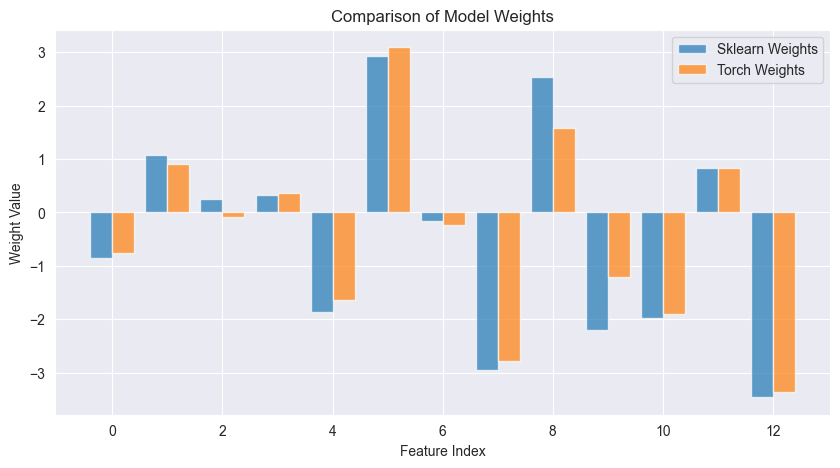

In [71]:
torch_weights = model[0].weight.detach().numpy().flatten()
sklearn_weights = lin_regression.coef_

plt.figure(figsize=(10, 5))
indices = np.arange(len(sklearn_weights))

plt.bar(indices - 0.2, sklearn_weights, width=0.4, label="Sklearn Weights", alpha=0.7)
plt.bar(indices + 0.2, torch_weights, width=0.4, label="Torch Weights", alpha=0.7)

plt.xlabel("Feature Index")
plt.ylabel("Weight Value")
plt.title("Comparison of Model Weights")
plt.legend()
plt.grid(True)
plt.show()

Реализуем две разных архитектуры нейросетей, которые принципиально отличаются друг от друга. Обучим каждую из них с двумя оптимизаторами: Adam и SGD. Визуализируем все траектории обучения на картинке.  

In [72]:
class BostonNnEasy(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, 1)
        )

    def forward(self, X):
        return self.model(X)


class BostonNnHard(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_features * 8),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_features * 8, hidden_features * 3),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_features * 3, 1)
        )

    def forward(self, X):
        return self.model(X)

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses):
    clear_output()
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='test')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()


def training_loop(model: nn.Module,
                  optimizer: torch.optim.Optimizer,
                  EPOCH: int,
                  loss_func: None,
                  train_dataloader: DataLoader,
                  y_val: torch.Tensor):
    optimizer = optimizer(model.parameters(), lr=0.01)
    criterion = loss_func()
    val_losses = []
    train_losses = []
    for epoch in range(EPOCH):
        train_loss = 0.0
        model.train()
        for batch in train_dataloader:
            X = batch['sample']
            y = batch['target'].float()
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.shape[0]

        train_loss /= len(train_dataloader.dataset)
        train_losses += [train_loss]

        model.eval()
        with torch.no_grad():
            logits = model(torch.from_numpy(X_test_norm).float())
            loss = criterion(logits, y_val)
            val_losses += [loss.item()]
    plot_losses(train_losses, val_losses)


# Простая модель с оптимайзером SGD

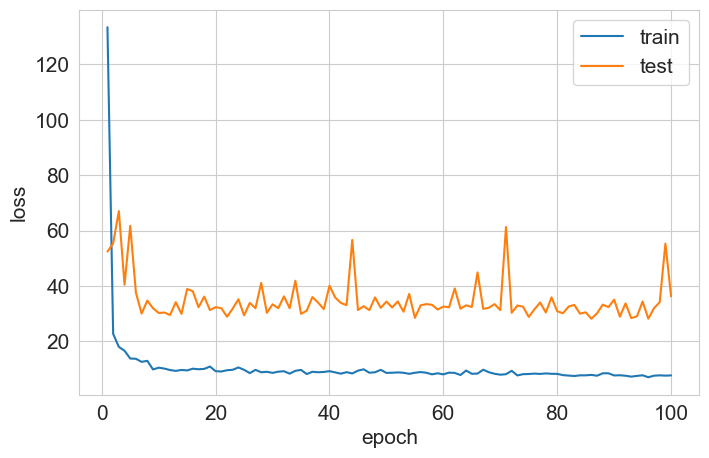

In [74]:
from torch.optim import SGD

EPOCH = 100
HIDDEN_SIZE = 8

easy_model_sgd = BostonNnEasy(in_features=X_train_dataset[0]['sample'].shape[0], hidden_features=HIDDEN_SIZE)
training_loop(easy_model_sgd, SGD, EPOCH, nn.MSELoss, X_train_loader, torch.from_numpy(y_test).unsqueeze(-1))

In [75]:
easy_model_sgd.eval()
with torch.no_grad():
    y_pred = easy_model_sgd(torch.from_numpy(X_test_norm).float())
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred.numpy())}")

MAPE: 0.14833825427357228


# Более сложная модель с оптимайзером SGD

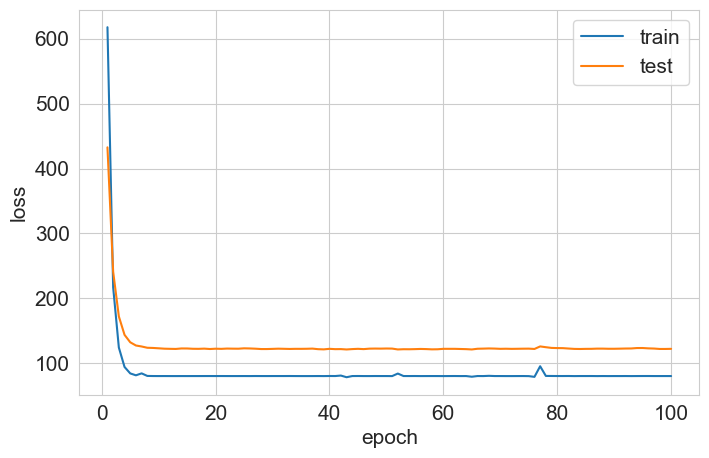

In [76]:
hard_model_sgd = BostonNnHard(in_features=X_train_dataset[0]['sample'].shape[0], hidden_features=HIDDEN_SIZE)
training_loop(hard_model_sgd, SGD, EPOCH, nn.MSELoss, X_train_loader, torch.from_numpy(y_test).float().unsqueeze(-1))

In [77]:
hard_model_sgd.eval()
with torch.no_grad():
    y_pred = hard_model_sgd(torch.from_numpy(X_test_norm).float())
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred.numpy())}")

MAPE: 0.3396972933061647


# Простая модель с оптимайзером ADAM

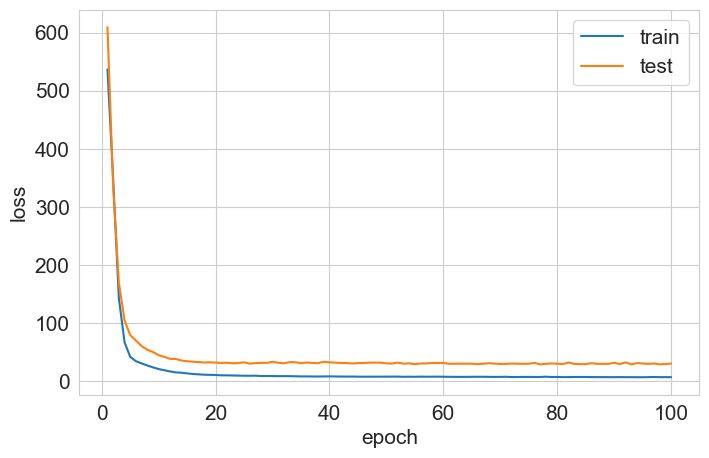

In [78]:
easy_model_adam = BostonNnEasy(in_features=X_train_dataset[0]['sample'].shape[0], hidden_features=HIDDEN_SIZE)
training_loop(easy_model_adam, Adam, EPOCH, nn.MSELoss, X_train_loader, torch.from_numpy(y_test).float().unsqueeze(-1))

In [79]:
easy_model_adam.eval()
with torch.no_grad():
    y_pred = easy_model_adam(torch.from_numpy(X_test_norm).float())
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred.numpy())}")

MAPE: 0.14476841363249643


# Более сложная модель с оптимайзером ADAM

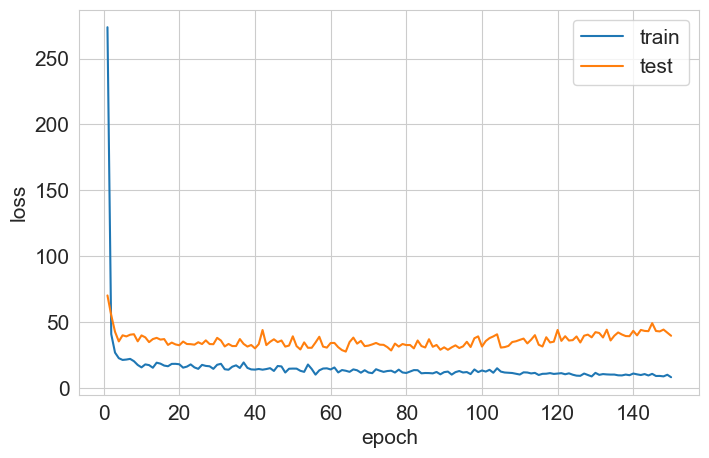

In [80]:
hard_model_adam = BostonNnHard(in_features=X_train_dataset[0]['sample'].shape[0], hidden_features=HIDDEN_SIZE)
training_loop(hard_model_adam, Adam, EPOCH + 50, nn.MSELoss, X_train_loader,
              torch.from_numpy(y_test).float().unsqueeze(-1))

In [81]:
hard_model_adam.eval()
with torch.no_grad():
    y_pred = hard_model_adam(torch.from_numpy(X_test_norm).float())
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred.numpy())}")

MAPE: 0.15756594213656916


# 4. Градиентные спуски
 

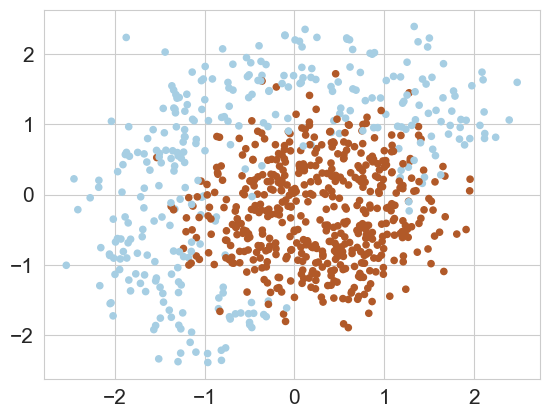

In [151]:
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True,
                               noise=0.2, factor=0.4, random_state=42)

ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

In [152]:
# добавим вектор из единичек
X = np.hstack((X, np.ones(X.shape[0])[:, np.newaxis]))
X

array([[ 1.20798057,  0.0844994 ,  1.        ],
       [ 0.76121787,  0.72510869,  1.        ],
       [ 0.55256189,  0.51937292,  1.        ],
       ...,
       [-1.22224754,  0.45743421,  1.        ],
       [ 0.43973452, -1.47275142,  1.        ],
       [ 1.4928118 ,  1.15683375,  1.        ]])

реализуем в `numpy` функцию для поиска вероятности того, что объект относится к первому классу


$$ \hat{y} = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$

 

In [153]:
def probability(X, w):
    y_pred = 1 / (1 + np.exp(-np.dot(X, w)))
    return y_pred

In [154]:
inp_test = np.array([[1, 2], [3, 4]])
out_test = np.array([1, 0])
weight_test = np.array([0.5, 0.5])

assert np.allclose(probability(inp_test, weight_test), np.array([0.81757448, 0.97068777]))

По аналогии реализуev логистические потери. 

$$ L(w) =  - {1 \over n} \sum_{i=1}^n \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$

In [155]:
def compute_loss(X, y, w):
    return -np.sum(y * np.log(probability(X, w)) + (1 - y) * np.log(1 - probability(X, w))) / X.shape[0]

In [156]:
assert compute_loss(inp_test, out_test, weight_test) - 1.865581 < 1e-3

$$ \nabla_w L = (P - y) * X$$

In [157]:
def compute_grad(X, y, w):
    return (probability(X, w) - y) @ X / X.shape[0]


In [158]:
assert np.allclose(compute_grad(inp_test, out_test, weight_test), np.array([1.36481889, 1.75895001]))

Функция ниже предназначена для визуализации процесса обучения. 

In [159]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


def visualize(X, y, w, history):
    Z = probability(np.c_[xx.ravel(), yy.ravel()], w[:-1])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

In [160]:
dummy_weights = np.linspace(-1, 1, 3)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

Mini-batch SGD 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



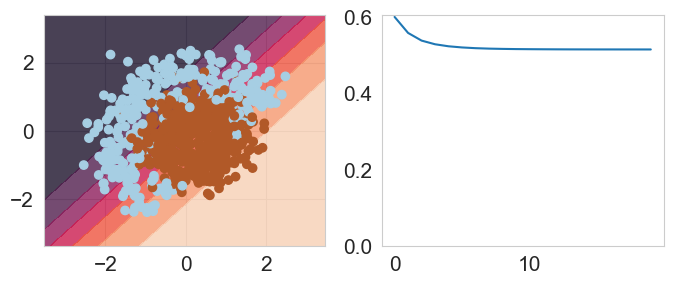

<Figure size 640x480 with 0 Axes>

In [180]:
np.random.seed(42)
w = np.array([0, 0, 1.])

eta = 0.01

n_iter = 20
loss = []
plt.figure(figsize=(12, 5))


def batch_generator(X, y, batch_size=4):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start in range(0, X.shape[0], batch_size):
        end = min(start + batch_size, X.shape[0])
        batch_indices = indices[start:end]
        yield X[batch_indices], y[batch_indices]


for i in range(n_iter):
    generator = batch_generator(X,y)
    for X_batch, y_batch in generator:
        output = X_batch @ w
        dldw = compute_grad(X_batch, y_batch, w)
        w -= eta * dldw
    loss.append(compute_loss(X, y, w))

visualize(X, y, w, loss)
plt.clf()

Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


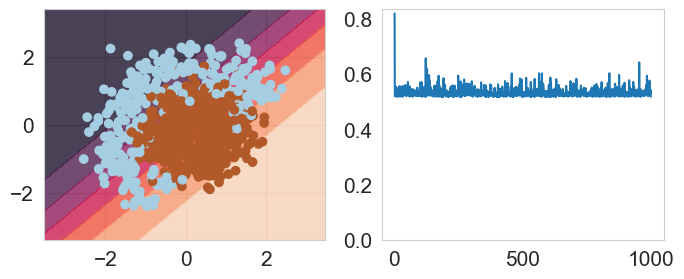

<Figure size 640x480 with 0 Axes>

In [186]:
np.random.seed(42)
w = np.array([0, 0, 100.])

eta = 0.05
alpha = 0.9
nu = np.zeros_like(w)

n_iter = 1000
batch_size = 4
loss = []
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    generator = batch_generator(X,y)
    for X_batch, y_batch in generator:
        output = X_batch @ w
        dldw = compute_grad(X_batch, y_batch, w)
        nu = alpha * nu + eta * dldw
        w -= nu
    loss.append(compute_loss(X, y, w))

visualize(X, y, w, loss)
plt.clf()